In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report,confusion_matrix

In [2]:
raw = pd.read_csv(r"C:\Users\iulia\OneDrive\Documents\Data Science\OnlineRetail.csv", 
                 encoding = "ISO-8859-1", 
                 parse_dates =['InvoiceDate'])

In [3]:
raw.sort_values(by='InvoiceDate', inplace = True)

In [4]:
raw.drop(raw[raw.InvoiceDate> '2011-12-01 00:00:00'].index, inplace = True)

In [5]:
raw['Revenue']=raw['UnitPrice']*raw['Quantity']

In [6]:
ref_date = raw.InvoiceDate.max()
customers = raw.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,                  
    'InvoiceNo': 'nunique',
    'Revenue': 'sum'}).reset_index()


customers.rename(columns = {'InvoiceDate': 'Recency',
                            'InvoiceNo': 'Frequency',
                            'Revenue': 'AnnualRevenue'}, inplace=True)

In [7]:
customers['MonthlyRevenue'] = (customers['AnnualRevenue']/12).round()
customers['AvgInvoice'] = (customers['AnnualRevenue']/customers['Frequency']).round()

In [8]:
customers

,CustomerID,Recency,Frequency,AnnualRevenue,MonthlyRevenue,AvgInvoice
0,12346.0,316,2,0.00,0.0,0.0
1,12347.0,30,6,4085.18,340.0,681.0
2,12348.0,66,4,1797.24,150.0,449.0
3,12349.0,9,1,1757.55,146.0,1758.0
4,12350.0,301,1,334.40,28.0,334.0
...,...,...,...,...,...,...
4326,18280.0,268,1,180.60,15.0,181.0
4327,18281.0,171,1,80.82,7.0,81.0
4328,18282.0,113,2,98.76,8.0,49.0
4329,18283.0,0,15,1886.88,157.0,126.0


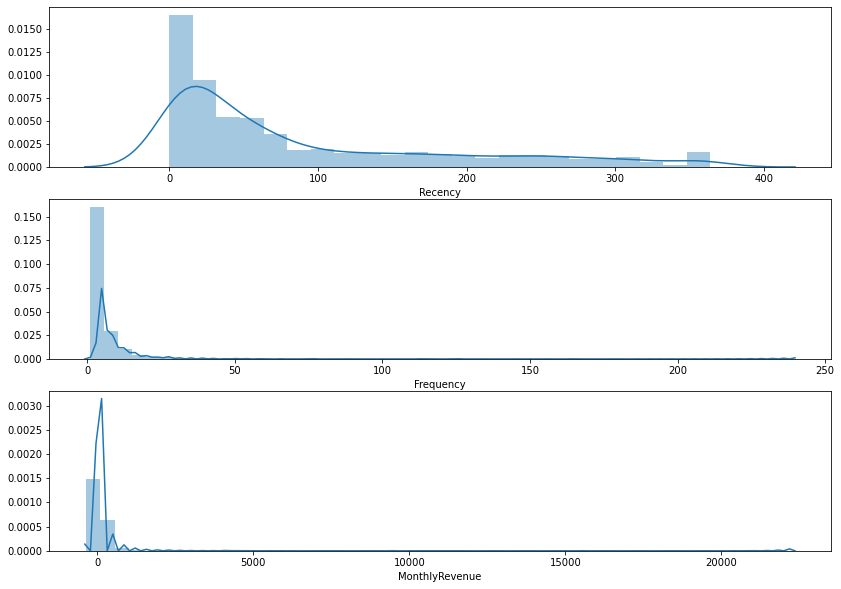

In [9]:
plt.figure(figsize=(14,10))
plt.subplot(3, 1, 1); 
sns.distplot(customers.Recency)
plt.subplot(3, 1, 2); 
sns.distplot(customers.Frequency)
plt.subplot(3, 1, 3); 
sns.distplot(customers.MonthlyRevenue)
plt.show()

In [10]:
r_labels = range(4, 0, -1)
f_labels = range(1, 5)
m_labels = range(1, 5)
r_groups = pd.qcut(customers['Recency'].rank(method='first'), q=4, labels=r_labels)
f_groups = pd.qcut(customers['Frequency'].rank(method='first'), q=4, labels=f_labels)
m_groups = pd.qcut(customers['MonthlyRevenue'], q=4, labels=m_labels)
customers = customers.assign(R = r_groups.values, F = f_groups.values, M = m_groups.values)
customers.head()

,CustomerID,Recency,Frequency,AnnualRevenue,MonthlyRevenue,AvgInvoice,R,F,M
0,12346.0,316,2,0.00,0.0,0.0,1,2,1
1,12347.0,30,6,4085.18,340.0,681.0,3,4,4
2,12348.0,66,4,1797.24,150.0,449.0,2,3,4
3,12349.0,9,1,1757.55,146.0,1758.0,4,1,4
4,12350.0,301,1,334.40,28.0,334.0,1,1,2


In [11]:
customers['RFM_Score'] = customers[['R','F','M']].sum(axis=1)

In [12]:
customers

,CustomerID,Recency,Frequency,AnnualRevenue,MonthlyRevenue,AvgInvoice,R,F,M,RFM_Score
0,12346.0,316,2,0.00,0.0,0.0,1,2,1,4
1,12347.0,30,6,4085.18,340.0,681.0,3,4,4,11
2,12348.0,66,4,1797.24,150.0,449.0,2,3,4,9
3,12349.0,9,1,1757.55,146.0,1758.0,4,1,4,9
4,12350.0,301,1,334.40,28.0,334.0,1,1,2,4
...,...,...,...,...,...,...,...,...,...,...
4326,18280.0,268,1,180.60,15.0,181.0,1,2,1,4
4327,18281.0,171,1,80.82,7.0,81.0,1,2,1,4
4328,18282.0,113,2,98.76,8.0,49.0,2,2,1,5
4329,18283.0,0,15,1886.88,157.0,126.0,4,4,4,12


In [13]:
def rfm_level(df):
    if df['RFM_Score'] >= 9:
        return 'Can\'t Loose Them'
    elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 9)):
        return 'Champions'
    elif ((df['RFM_Score'] >= 7) and (df['RFM_Score'] < 8)):
        return 'Loyal'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 7)):
        return 'Potential'
    elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 6)):
        return 'Promising'
    elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 5)):
        return 'Needs Attention'
    else:
        return 'Require Activation'

In [14]:
customers['RFM_Level'] = customers.apply(rfm_level, axis=1)

In [15]:
customers

,CustomerID,Recency,Frequency,AnnualRevenue,MonthlyRevenue,AvgInvoice,R,F,M,RFM_Score,RFM_Level
0,12346.0,316,2,0.00,0.0,0.0,1,2,1,4,Needs Attention
1,12347.0,30,6,4085.18,340.0,681.0,3,4,4,11,Can't Loose Them
2,12348.0,66,4,1797.24,150.0,449.0,2,3,4,9,Can't Loose Them
3,12349.0,9,1,1757.55,146.0,1758.0,4,1,4,9,Can't Loose Them
4,12350.0,301,1,334.40,28.0,334.0,1,1,2,4,Needs Attention
...,...,...,...,...,...,...,...,...,...,...,...
4326,18280.0,268,1,180.60,15.0,181.0,1,2,1,4,Needs Attention
4327,18281.0,171,1,80.82,7.0,81.0,1,2,1,4,Needs Attention
4328,18282.0,113,2,98.76,8.0,49.0,2,2,1,5,Promising
4329,18283.0,0,15,1886.88,157.0,126.0,4,4,4,12,Can't Loose Them


In [16]:
Segments = customers.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonthlyRevenue': 'mean', 
    'CustomerID':'count'
}).round().reset_index()

In [17]:
Segments

,RFM_Level,Recency,Frequency,MonthlyRevenue,CustomerID
0,Can't Loose Them,25.0,10.0,334.0,1678
1,Champions,58.0,3.0,79.0,414
2,Loyal,72.0,2.0,53.0,463
3,Needs Attention,203.0,1.0,19.0,481
4,Potential,92.0,2.0,38.0,480
5,Promising,132.0,1.0,28.0,504
6,Require Activation,266.0,1.0,11.0,311


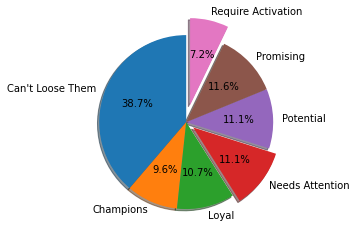

In [18]:
labels ='Can\'t Loose Them','Champions','Loyal','Needs Attention','Potential', 'Promising', 'Require Activation'
sizes = Segments['CustomerID']
explode = (0, 0, 0, 0.1, 0, 0, 0.2)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)

plt.show()

In [19]:
df = raw.groupby([raw.CustomerID, pd.Grouper(freq='M', key='InvoiceDate')]).Revenue.sum().reset_index()

In [20]:
df['month'] = df.InvoiceDate.dt.month
df['year'] = df.InvoiceDate.dt.year
df['quarter'] = df.InvoiceDate.dt.quarter

In [21]:
df.sort_values(by='InvoiceDate', inplace = True, ignore_index=True)

In [22]:
df= df.merge(customers, how='left')

In [23]:
#creating 4 clusters with KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(df[['Revenue']])
df['LTVCluster'] = kmeans.predict(df[['Revenue']])

In [24]:
df

,CustomerID,InvoiceDate,Revenue,month,year,quarter,Recency,Frequency,AnnualRevenue,MonthlyRevenue,AvgInvoice,R,F,M,RFM_Score,RFM_Level,LTVCluster
0,15224.0,2010-12-31,310.48,12,2010,4,349,3,310.48,26.0,103.0,1,3,2,6,Potential,1
1,15298.0,2010-12-31,397.60,12,2010,4,1,13,3461.88,288.0,266.0,4,4,4,12,Can't Loose Them,1
2,15299.0,2010-12-31,1835.01,12,2010,4,58,11,3787.09,316.0,344.0,2,4,4,10,Can't Loose Them,1
3,15301.0,2010-12-31,673.37,12,2010,4,41,14,5028.12,419.0,359.0,3,4,4,11,Can't Loose Them,1
4,15304.0,2010-12-31,123.15,12,2010,4,51,10,680.30,57.0,68.0,2,4,3,9,Can't Loose Them,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12984,14834.0,2011-11-30,525.16,11,2011,4,8,8,1698.35,142.0,212.0,4,4,4,12,Can't Loose Them,1
12985,14836.0,2011-11-30,102.45,11,2011,4,1,3,102.45,9.0,34.0,4,3,1,8,Champions,1
12986,12600.0,2011-11-30,379.58,11,2011,4,19,11,2581.04,215.0,235.0,3,4,4,11,Can't Loose Them,1
12987,14842.0,2011-11-30,-50.74,11,2011,4,26,8,2456.80,205.0,307.0,3,4,4,11,Can't Loose Them,1


In [25]:
pipe = make_pipeline(OrdinalEncoder(), xgb.XGBClassifier())

In [26]:
X = df.drop(['LTVCluster', 'Revenue','InvoiceDate'], axis=1)
y = df['LTVCluster']

In [27]:
X_train = X.loc[:11277]
X_test = X.loc[11278:]
y_train = y.loc[:11277]
y_test = y.loc[11278:]

In [28]:
pipe.fit(X_train,y_train).score(X_test,y_test)

0.9772063120981882

In [29]:
feat_importance = pd.DataFrame({
    'feature':X.columns,
    'importance' : pipe.steps[1][1].feature_importances_
})
feat_importance.set_index('feature').sort_values(by='importance', ascending = False)

,importance
feature,
AnnualRevenue,0.485085
F,0.101200
AvgInvoice,0.092743
RFM_Score,0.082854
Frequency,0.053916
Recency,0.052399
RFM_Level,0.048845
month,0.042170
CustomerID,0.040787


In [32]:

print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(pipe.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on test set: 0.98


In [33]:

y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.45      0.50        40
           1       0.99      0.99      0.99      1664
           2       0.33      0.14      0.20         7

    accuracy                           0.98      1711
   macro avg       0.63      0.53      0.56      1711
weighted avg       0.97      0.98      0.98      1711

